<H1> Enhancement of a general topological signal by scPrisma</h1>

In this tutorial, we will demonstrate how to enhance the variance which is explained by a covarainace matrix which is provided by the user.

Few design principles for designing theoretical covariance matrix:
1. scPrisma was designed for continuous topologies, and especially circular topologies (were we have a closed formula for the spectrum). The ideal design procedure is to create a "toy model" for the desired topology (as been done for the circular topology in the "Methods" section), compute its covariance matrix and perform numerical eigen decomposition. Note: as been writen in the discussion, for complex topologies (other than cyclic) the reconstruction task can be challenging.
2. The covariance matrix should to be a symmetric PSD matrix (to enable numerical eigendecomposition) with ones over the diagonal of the matrix.
3. In some scenarios, it is recommended to eliminate the dominant eigenvector, particularly when it is an 'offset' eigenvector, as in the case of a cyclic covariance matrix, where the lead eigenvector is a constant.

The example used in this tutorial is based on scRNA-seq data of mice liver samples which were sequenced at four equally-spaced time points along the day. The data was taken from <a href="https://www.nature.com/articles/s42255-020-00323-1">Droin, Colas, et al. Nature metabolism (2021)</a>. 


In [1]:
import copy
import time
import matplotlib.pyplot as plt
import numpy as np
import scPrisma
import scanpy as sc
n_obs=1000 #number of observations per timepoint
import torch
import pandas as pd

Read the dataset files functions.</a>.

In [2]:
def read_cr_single_file_layer(path,layer_path,ZT="0" , n_obs=300):
    adata = sc.read_csv(path, delimiter='\t').T
    adata.var_names_make_unique()
    adata.obs_names_make_unique()
    adata.obs['ZT'] = ZT
    layers = cr_layer_read(layer_path)
    adata.obs['layer']=layers
    sc.pp.subsample(adata,n_obs=n_obs , random_state=123)
    return adata

def cr_layer_read(path):
    df = pd.read_csv(path, delimiter=',' , header=None)
    position_matrx = df.to_numpy()
    layers_array = np.zeros(position_matrx.shape[0])
    for i in range(position_matrx.shape[0]):
        layers_array[i]=position_matrx[i,:].argmax()
    return layers_array

def read_liver_data(n_obs=250):
    n_obs=int(n_obs/2)
    adata = read_cr_single_file_layer("liver/GSM4308343_UMI_tab_ZT00A.txt", layer_path="liver/ZT00A_reco.txt", ZT="0",
                                      n_obs=n_obs)
    adata.var_names_make_unique()
    adata.obs_names_make_unique()
    adata1 = read_cr_single_file_layer("liver/GSM4308344_UMI_tab_ZT00B.txt", layer_path="liver/ZT00B_reco.txt", ZT="0",
                                      n_obs=n_obs)
    adata1.var_names_make_unique()
    adata1.obs_names_make_unique()
    adata=adata.concatenate(adata1)
    adata.var_names_make_unique()
    adata.obs_names_make_unique()
    adata2 = read_cr_single_file_layer("liver/GSM4308346_UMI_tab_ZT06A.txt", layer_path="liver/ZT06A_reco.txt", ZT="6",
                                      n_obs=n_obs)
    adata2.obs_names_make_unique()
    adata2.var_names_make_unique()
    adata3 = read_cr_single_file_layer("liver/GSM4308347_UMI_tab_ZT06B.txt", layer_path="liver/ZT06B_reco.txt", ZT="6",
                                      n_obs=n_obs)
    adata3.obs_names_make_unique()
    adata3.var_names_make_unique()
    adata2=adata2.concatenate(adata3)
    adata2.var_names_make_unique()
    adata2.obs_names_make_unique()

    adata4 = read_cr_single_file_layer("liver/GSM4308348_UMI_tab_ZT12A.txt", layer_path="liver/ZT12A_reco.txt", ZT="12", n_obs=n_obs)
    adata4.var_names_make_unique()
    adata4.obs_names_make_unique()
    adata5 = read_cr_single_file_layer("liver/GSM4308349_UMI_tab_ZT12B.txt", layer_path="liver/ZT12B_reco.txt", ZT="12",
                                      n_obs=n_obs)
    adata5.var_names_make_unique()
    adata5.obs_names_make_unique()
    adata4=adata4.concatenate(adata5)
    adata4.var_names_make_unique()
    adata4.obs_names_make_unique()

    adata6 = read_cr_single_file_layer("liver/GSM4308351_UMI_tab_ZT18A.txt", layer_path="liver/ZT18A_reco.txt", ZT="18",
                                      n_obs=n_obs)
    adata6.var_names_make_unique()
    adata6.obs_names_make_unique()
    adata7 = read_cr_single_file_layer("liver/GSM4308352_UMI_tab_ZT18B.txt", layer_path="liver/ZT18B_reco.txt", ZT="18",
                                      n_obs=n_obs)
    adata7.var_names_make_unique()
    adata7.obs_names_make_unique()
    adata6=adata6.concatenate(adata7)
    adata6.var_names_make_unique()
    adata6.obs_names_make_unique()

    adata = adata.concatenate(adata2, adata4, adata6)
    adata.var_names_make_unique()
    adata.obs_names_make_unique()
    return adata


<h2>Data read and sorting according to "Zeitgeber Time" </h2> <br />
The function "sort_data_crit" sorts the data according to an observation of the field that is inserted as 'crit', in the order of 'crit_list'.

In [3]:
adata = read_liver_data(n_obs) #read data
adata = scPrisma.algorithms_torch.sort_data_crit(adata=copy.deepcopy(adata.copy()),crit='ZT',crit_list=['0','6','12','18']) #sort the data according to the timepoints
adata

/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/c

View of AnnData object with n_obs × n_vars = 4000 × 14812
    obs: 'ZT', 'layer', 'batch'

<h2>Standard pre-processing</h2> <br />
It is recommended to not scale the data to zero mean

In [4]:
#standard pre-processing
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.filter_genes_dispersion(adata, n_top_genes=7000)
orig_adata = copy.deepcopy(adata.copy())



/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Plotting

/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


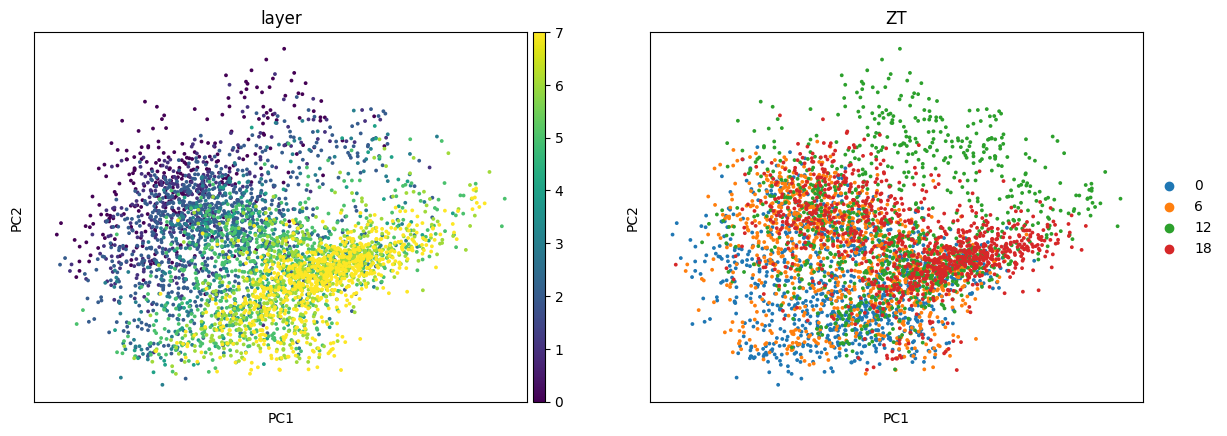

In [5]:
sc.pp.pca(adata)
sc.pl.pca(adata, color=['layer','ZT'])

<h2>Day-night covariance matrix design<h2>

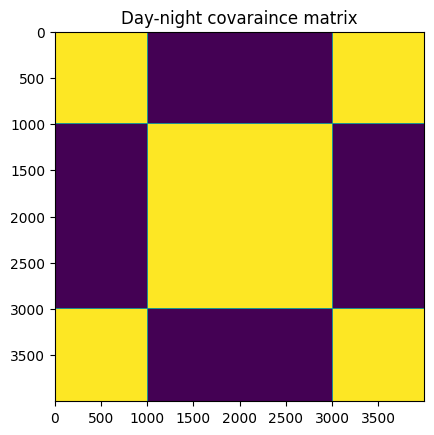

In [6]:
cov = np.zeros((adata.shape[0],adata.shape[0]))
for i , j in enumerate(adata.obs["ZT"]):
        if j=='18' or j=='0':
            cov[i,:]+=np.array(adata.obs["ZT"]=='0',dtype=int)
            cov[i,:]+=np.array(adata.obs["ZT"]=='18',dtype=int)
        else:
            cov[i,:]+=np.array(adata.obs["ZT"]=='6',dtype=int)
            cov[i,:]+=np.array(adata.obs["ZT"]=='12',dtype=int)
plt.imshow(cov)
plt.title("Day-night covariance matrix")
plt.show()

<h2> Genes inference</h2>
Instead of using the exact gene inference algorithm described in the manuscript, we will select a fixed number of genes to retain based on their projection over the theoretical spectrum. This is similar to tuning the regularization parameter so that this number of genes is retained.

In [7]:
D = scPrisma.algorithms_torch.filter_general_genes_by_proj_torch(adata.X,cov,n_genes=1000)

In [8]:
adata.X = adata.X @ D

<h2> Day-night enhancement</h2>

In [9]:
F = scPrisma.algorithms_torch.enhance_general_covariance_torch(adata.X,cov, iterNum=100,regu=10)

Iteration number: 1
torch.cuda.memory_allocated: 0.000000GB


In [10]:
adata.X = adata.X *F

/cs/labs/mornitzan/karinjo/miniconda/envs/scprisma_gpu/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


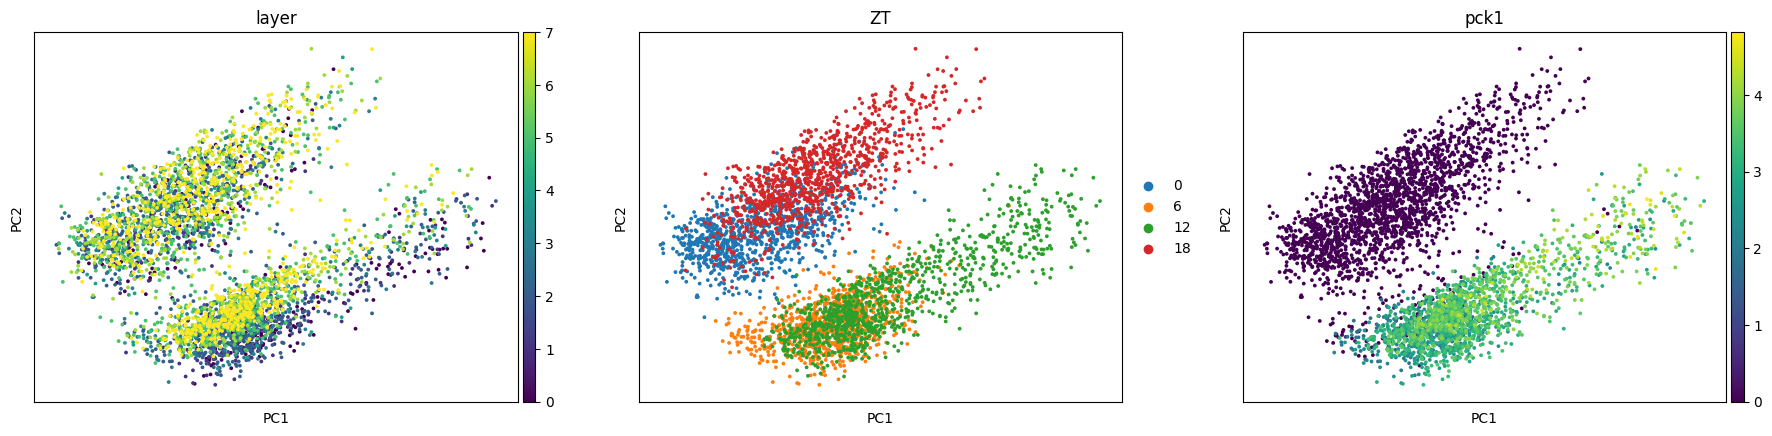

In [11]:
sc.pp.pca(adata)
sc.pl.pca(adata, color=['layer','ZT','pck1'])